
Approx Newton (linear):
 - Time Taken: 0.0047s
 - Iterations: 15
 - Final Gradient Norm: 1.78e-03
 - Total CG Steps: 118

Approx Newton (superlinear):
 - Time Taken: 0.0057s
 - Iterations: 11
 - Final Gradient Norm: 1.72e-09
 - Total CG Steps: 142

Approx Newton (quadratic):
 - Time Taken: 0.0025s
 - Iterations: 10
 - Final Gradient Norm: 5.23e-09
 - Total CG Steps: 130

Classical Newton:
 - Time Taken: 0.0484s
 - Iterations: 2
 - Final Gradient Norm: 2.11e-14
 - Total CG Steps: 0

Steepest Descent:
 - Time Taken: 0.0080s
 - Iterations: 15
 - Final Gradient Norm: 4.94e+02
 - Total CG Steps: 0


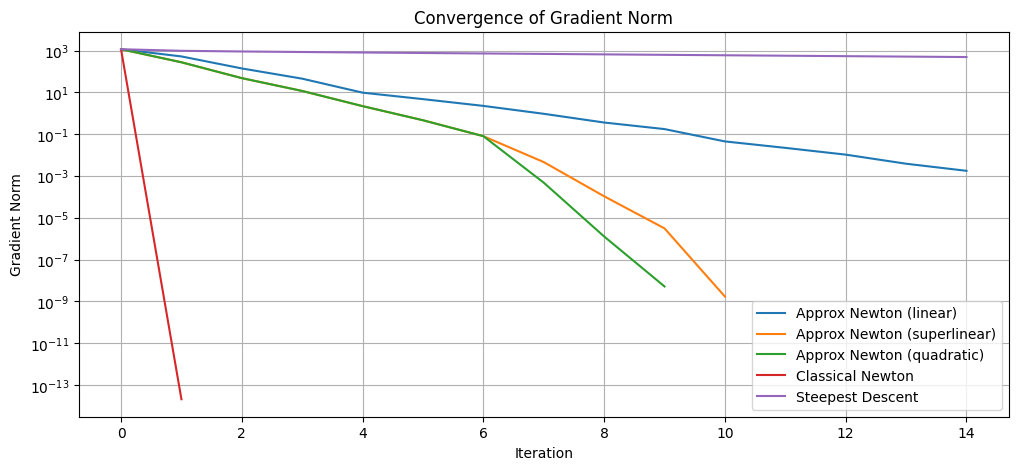

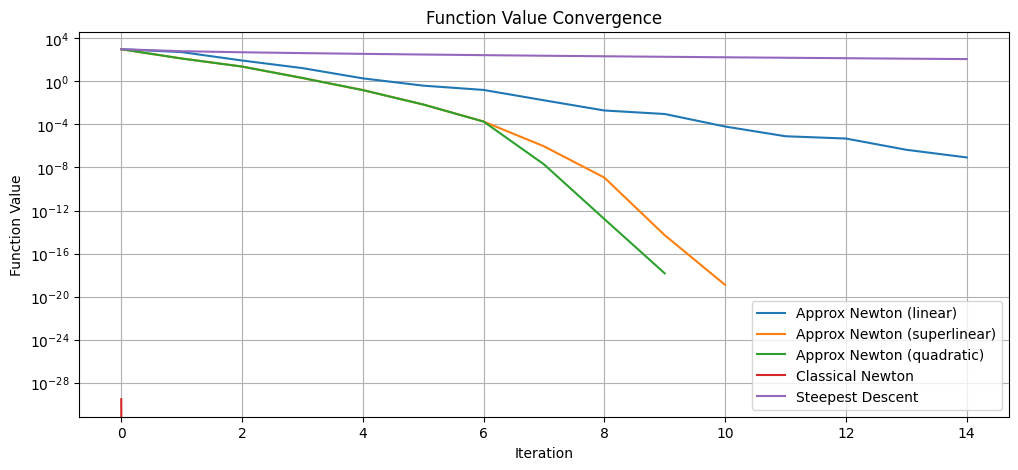

In [43]:
import numpy as np
import time
from case_studies import *  # Assuming implemented test functions
from math import sqrt

def is_positive_definite(H):
    try:
        np.linalg.cholesky(H)
        return True
    except np.linalg.LinAlgError:
        return False

def conjugate_gradient(Q, g, tol=1e-6, max_iter=None):
    n = len(g)
    if max_iter is None:
        max_iter = n
    
    x = np.zeros(n)
    r = -g.copy()  # Initial residual
    p = r.copy()
    rs_old = r.dot(r)
    
    for i in range(max_iter):
        Ap = Q @ p
        alpha = rs_old / p.dot(Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = r.dot(r)
        
        if np.sqrt(rs_new) < tol:
            break
        
        beta = rs_new / rs_old
        p = r + beta * p
        rs_old = rs_new
    
    return x, i + 1

def approximate_newton(x0, f, df, Hf, eta_type='linear', alpha=1e3, 
                      tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'cg_steps': [], 'fval': []}
    
    for k in range(1, max_iter+1):
        g = df(x, alpha)
        Q = Hf(x, alpha)
        
        if not is_positive_definite(Q):
            raise ValueError("Hessian not positive definite")
        
        norm_g = np.linalg.norm(g)
        
        if eta_type == "linear":
            eta_k = 1/2  # Fixed value, slow convergence
        elif eta_type == "superlinear":
            eta_k = 1/2 * min(1/2, sqrt(norm_g))
        elif eta_type == "quadratic":
            eta_k = 1/2 * min(1/2, norm_g)
        else:
            raise ValueError("Invalid eta_type. Choose from 'linear', 'superlinear', 'quadratic'.")
        
        eps_k = eta_k * norm_g  # CG stopping criterion
        
        p, cg_steps = conjugate_gradient(Q, g, tol=eps_k)
        
        # Armijo line search
        step = 1.0
        f0 = f(x, alpha)
        while f(x + step*p, alpha) > f0 + 1e-4*step*g.dot(p):
            step *= 0.5
        
        x += step*p
        
        # Track convergence
        history['grad_norm'].append(np.linalg.norm(g))
        history['cg_steps'].append(cg_steps)
        history['fval'].append(f0)
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

def newtons_method(x0, f, df, Hf, alpha=1e3, tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'fval': []}
    
    for _ in range(max_iter):
        g = df(x, alpha)
        Q = Hf(x, alpha)
        p = np.linalg.solve(Q, -g)
        x += p
        
        history['grad_norm'].append(np.linalg.norm(g))
        history['fval'].append(f(x, alpha))
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

def steepest_descent(x0, f, df, alpha=1e3, tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'fval': []}
    
    for _ in range(max_iter):
        g = df(x, alpha)
        p = -g
        
        # Line search
        step = 1.0
        f0 = f(x, alpha)
        while f(x + step*p, alpha) > f0 - 1e-4*step*g.dot(g):
            step *= 0.5
        
        x += step*p
        
        history['grad_norm'].append(np.linalg.norm(g))
        history['fval'].append(f0)
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

# Benchmarking setup
d = 20
x0 = np.random.randn(d)
methods = {
    'Approx Newton (linear)': lambda: approximate_newton(x0, f1, df1, Hf1, 'linear'),
    'Approx Newton (superlinear)': lambda: approximate_newton(x0, f1, df1, Hf1, 'superlinear'),
    'Approx Newton (quadratic)': lambda: approximate_newton(x0, f1, df1, Hf1, 'quadratic'),
    'Classical Newton': lambda: newtons_method(x0, f1, df1, Hf1),
    'Steepest Descent': lambda: steepest_descent(x0, f1, df1)
}

# Run benchmarks
results = {}
for name, method in methods.items():
    start = time.time()
    x_opt, hist = method()
    elapsed = time.time() - start
    results[name] = {
        'time': elapsed,
        'iterations': len(hist['grad_norm']),
        'final_grad': hist['grad_norm'][-1],
        'cg_steps': sum(hist.get('cg_steps', [])),
        'convergence': hist['grad_norm'],
        'function_values' : hist['fval']
    }

# Generate convergence plots and analysis
# Print results
for name, res in results.items():
    print(f"\n{name}:")
    print(f" - Time Taken: {res['time']:.4f}s")
    print(f" - Iterations: {res['iterations']}")
    print(f" - Final Gradient Norm: {res['final_grad']:.2e}")
    if 'cg_steps' in res:
        print(f" - Total CG Steps: {res['cg_steps']}")

# Plot convergence
plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['convergence'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Convergence of Gradient Norm')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['function_values'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Function Value Convergence')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


Approx Newton (linear):
 - Time Taken: 0.1038s
 - Iterations: 15
 - Final Gradient Norm: 2.69e-02
 - Total CG Steps: 168

Approx Newton (superlinear):
 - Time Taken: 0.0293s
 - Iterations: 12
 - Final Gradient Norm: 1.06e-07
 - Total CG Steps: 426

Approx Newton (quadratic):
 - Time Taken: 0.0167s
 - Iterations: 11
 - Final Gradient Norm: 1.90e-09
 - Total CG Steps: 555

Classical Newton:
 - Time Taken: 0.0042s
 - Iterations: 2
 - Final Gradient Norm: 2.51e-13
 - Total CG Steps: 0

Steepest Descent:
 - Time Taken: 0.0042s
 - Iterations: 15
 - Final Gradient Norm: 8.27e+02
 - Total CG Steps: 0


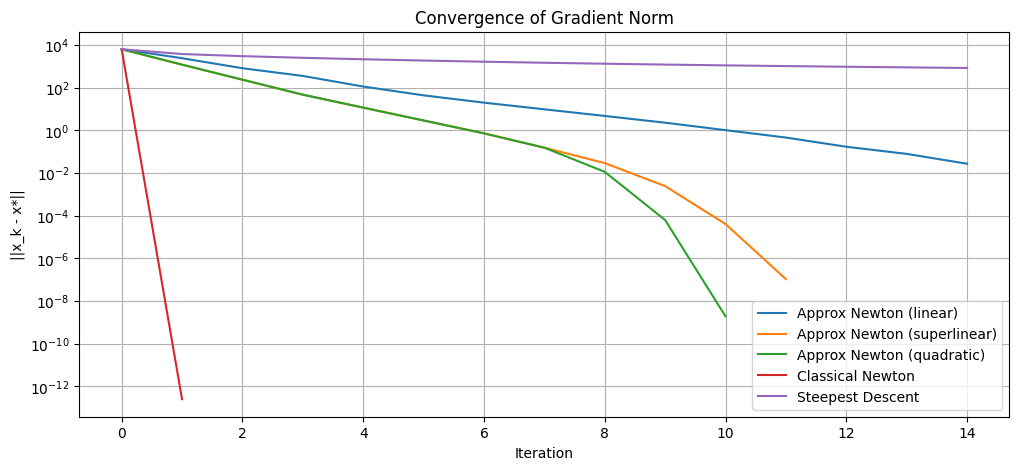

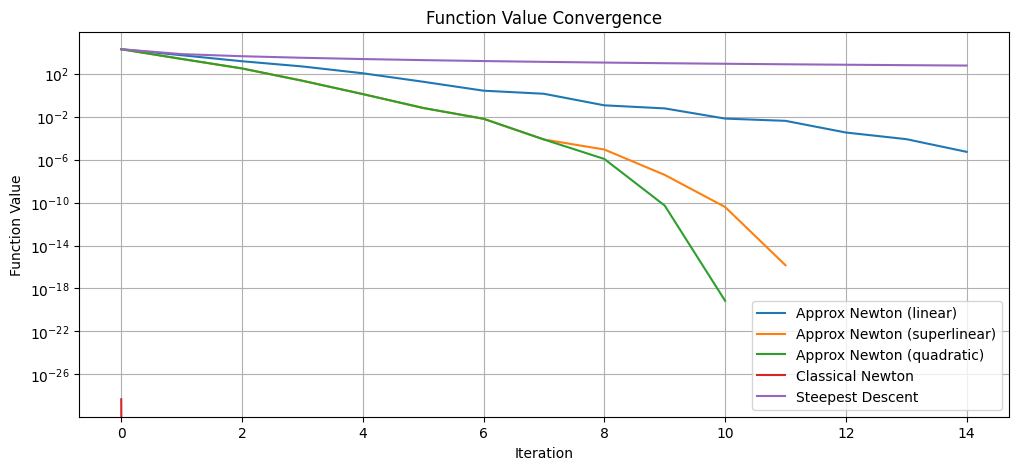

In [46]:
import numpy as np
import time
from case_studies import *  # Assuming implemented test functions
from math import sqrt

def is_positive_definite(H):
    try:
        np.linalg.cholesky(H)
        return True
    except np.linalg.LinAlgError:
        return False

def conjugate_gradient(Q, g, tol=1e-6, max_iter=None):
    n = len(g)
    if max_iter is None:
        max_iter = n
    
    x = np.zeros(n)
    r = -g.copy()  # Initial residual
    p = r.copy()
    rs_old = r.dot(r)
    
    for i in range(max_iter):
        Ap = Q @ p
        alpha = rs_old / p.dot(Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = r.dot(r)
        
        if np.sqrt(rs_new) < tol:
            break
        
        beta = rs_new / rs_old
        p = r + beta * p
        rs_old = rs_new
    
    return x, i + 1

def approximate_newton(x0, f, df, Hf, eta_type='linear', alpha=1e3, 
                      tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'cg_steps': [], 'fval': []}
    
    for k in range(1, max_iter+1):
        g = df(x, alpha)
        Q = Hf(x, alpha)
        
        if not is_positive_definite(Q):
            raise ValueError("Hessian not positive definite")
        
        norm_g = np.linalg.norm(g)
        
        if eta_type == "linear":
            eta_k = 1/2  # Fixed value, slow convergence
        elif eta_type == "superlinear":
            eta_k = 1/2 * min(1/2, sqrt(norm_g))
        elif eta_type == "quadratic":
            eta_k = 1/2 * min(1/2, norm_g)
        else:
            raise ValueError("Invalid eta_type. Choose from 'linear', 'superlinear', 'quadratic'.")
        
        eps_k = eta_k * norm_g  # CG stopping criterion
        
        p, cg_steps = conjugate_gradient(Q, g, tol=eps_k)
        
        # Armijo line search
        step = 1.0
        f0 = f(x, alpha)
        while f(x + step*p, alpha) > f0 + 1e-4*step*g.dot(p):
            step *= 0.5
        
        x += step*p
        
        # Track convergence
        history['grad_norm'].append(np.linalg.norm(g))
        history['cg_steps'].append(cg_steps)
        history['fval'].append(f0)
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

def newtons_method(x0, f, df, Hf, alpha=1e3, tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'fval': []}
    
    for _ in range(max_iter):
        g = df(x, alpha)
        Q = Hf(x, alpha)
        p = np.linalg.solve(Q, -g)
        x += p
        
        history['grad_norm'].append(np.linalg.norm(g))
        history['fval'].append(f(x, alpha))
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

def steepest_descent(x0, f, df, alpha=1e3, tol=1e-6, max_iter=15):
    x = x0.copy()
    history = {'grad_norm': [], 'fval': []}
    
    for _ in range(max_iter):
        g = df(x, alpha)
        p = -g
        
        # Line search
        step = 1.0
        f0 = f(x, alpha)
        while f(x + step*p, alpha) > f0 - 1e-4*step*g.dot(g):
            step *= 0.5
        
        x += step*p
        
        history['grad_norm'].append(np.linalg.norm(g))
        history['fval'].append(f0)
        
        if history['grad_norm'][-1] < tol:
            break
    
    return x, history

# Benchmarking setup
d = 200
x0 = np.random.randn(d)
methods = {
    'Approx Newton (linear)': lambda: approximate_newton(x0, f1, df1, Hf1, 'linear'),
    'Approx Newton (superlinear)': lambda: approximate_newton(x0, f1, df1, Hf1, 'superlinear'),
    'Approx Newton (quadratic)': lambda: approximate_newton(x0, f1, df1, Hf1, 'quadratic'),
    'Classical Newton': lambda: newtons_method(x0, f1, df1, Hf1),
    'Steepest Descent': lambda: steepest_descent(x0, f1, df1)
}

# Run benchmarks
results = {}
for name, method in methods.items():
    start = time.time()
    x_opt, hist = method()
    elapsed = time.time() - start
    results[name] = {
        'time': elapsed,
        'iterations': len(hist['grad_norm']),
        'final_grad': hist['grad_norm'][-1],
        'cg_steps': sum(hist.get('cg_steps', [])),
        'convergence': hist['grad_norm'],
        'function_values' : hist['fval']
    }

# Generate convergence plots and analysis
# Print results
for name, res in results.items():
    print(f"\n{name}:")
    print(f" - Time Taken: {res['time']:.4f}s")
    print(f" - Iterations: {res['iterations']}")
    print(f" - Final Gradient Norm: {res['final_grad']:.2e}")
    if 'cg_steps' in res:
        print(f" - Total CG Steps: {res['cg_steps']}")

# Plot convergence
plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['convergence'], label=name)
plt.xlabel('Iteration')
plt.ylabel('||x_k - x*||')
plt.title('Convergence of Gradient Norm')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
for name, res in results.items():
    plt.plot(res['function_values'], label=name)
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Function Value Convergence')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()